# Malicious URL CLassification

In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib.colors import hex2color
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from nltk import ngrams

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

import joblib

## Import the dataset

In [2]:
# DATASET_FILE = "./datasets/malicious_phish.csv" # Original dataset
DATASET_FILE = "./datasets/combined_urls.csv" # Combined dataset (original + generated)

df = pd.read_csv(DATASET_FILE)

df.rename(columns={"type": "target"}, inplace=True)
df['target'] = df['target'].map(lambda x: 'malicious' if x != 'benign' else 'benign')

df["target"].value_counts()


target
benign       428103
malicious    223088
Name: count, dtype: int64

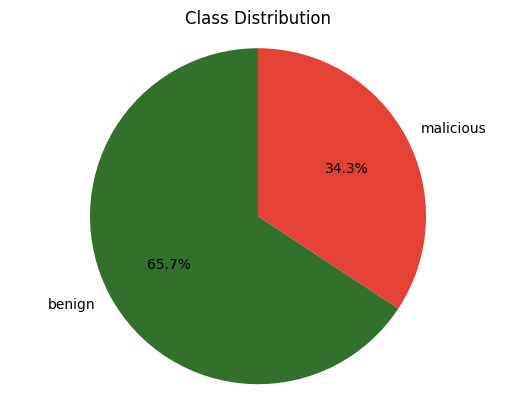

In [3]:
distribution = dict(df["target"].value_counts())

# Set up the figure with a white background
fig, ax = plt.subplots(facecolor='white')

dull_red = hex2color('#E34234')
dull_green = hex2color('#32712C')

# Plotting the pie chart
ax.pie(distribution.values(), labels=distribution.keys(), colors=[dull_green, dull_red], autopct='%1.1f%%', startangle=90)
ax.set_title('Class Distribution')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()

## URL Tokenization and Word Embedding with Word2Vec

In [4]:
def preprocess_url(url):
    # Remove sequential strings following '#' and '?'
    url = re.sub(r"#.*", "", url)
    url = re.sub(r"\?.*", "", url)

    # Split the URL into protocol and rest (domain, path and file)
    protocol, rest = url.split("://", 1) if "://" in url else ("", url)

    # Split the rest into domain and rest (path and file)
    domain, rest = rest.split("/", 1) if "/" in rest else (rest, "")
    
    # Split the rest into path and file
    path, file = rest.rsplit("/", 1) if "/" in rest else (rest, "")

    return [protocol, domain, path, file]

# Token extraction
tokenized_urls = [preprocess_url(url) for url in df['url'].tolist()]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_urls, vector_size=100, window=5, min_count=1, workers=4)
model.save("models/word2vec_model.model")

In [5]:
model = Word2Vec.load("models/word2vec_model.model")

In [6]:
# Function to get the aggregated embedding for a URL
def get_url_embedding(url_tokens, model):
    embeddings = [model.wv[token] for token in url_tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Generate embeddings for each URL
url_embeddings = [get_url_embedding(url_token, model) for url_token in tokenized_urls]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(url_embeddings, df['target'].tolist(), test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the basic statistics of the training set
data_counts = {
    "train": pd.Series(y_train).value_counts().to_list(),
    "test": pd.Series(y_test).value_counts().to_list(),
    "validation": pd.Series(y_val).value_counts().to_list(),
    "total": pd.Series(df['target'].tolist()).value_counts().to_list(),
}
pd.DataFrame(data_counts, index=["benign", "malicious"])

,train,test,validation,total
benign,342325,42748,43030,428103
malicious,178627,22371,22090,223088


## Naive Bayes Classifier

In [20]:
nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

joblib.dump(nb_classifier, "models/nb_classifier.joblib")

['models/nb_classifier.joblib']

In [21]:
nb_classifier = joblib.load("models/nb_classifier.joblib")

nb_classifier.score(X_test, y_test)

0.825289086134615

In [22]:
y_pred = nb_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["benign", "malicious"], zero_division=0, digits=4))

              precision    recall  f1-score   support

      benign     0.8530    0.8866    0.8695     42748
   malicious     0.7657    0.7081    0.7358     22371

    accuracy                         0.8253     65119
   macro avg     0.8094    0.7973    0.8026     65119
weighted avg     0.8230    0.8253    0.8236     65119



## Random Forest Classifier

In [23]:
rf_classifier = RandomForestClassifier(n_estimators=10, n_jobs=10)

rf_classifier.fit(X_train, y_train)

joblib.dump(rf_classifier, "models/rf_classifier.joblib")

['models/rf_classifier.joblib']

In [26]:
rf_classifier = joblib.load("models/rf_classifier.joblib")

# Tune hyperparameters using X_val and y_val
rf_classifier.score(X_val, y_val)

0.9078470515970516

In [18]:
y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["benign", "malicious"], zero_division=0, digits=4))

              precision    recall  f1-score   support

      benign     0.8890    0.9800    0.9323     42748
   malicious     0.9525    0.7661    0.8492     22371

    accuracy                         0.9065     65119
   macro avg     0.9207    0.8731    0.8907     65119
weighted avg     0.9108    0.9065    0.9037     65119

